# Лабораторная работа №5. Проведение исследований с градиентным бустингом

## Создание бейзлайна и оценка качества

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, confusion_matrix, 
                             mean_squared_error, mean_absolute_error, r2_score,
                             precision_score, recall_score)
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn.metrics import ConfusionMatrixDisplay

### Классификация

Загрузка датасета

In [2]:
df_class = pd.read_csv('datasets/online_shoppers_intention.csv')

Размер датасета

In [3]:
df_class.shape

(12330, 18)

Первые 5 строк

In [4]:
df_class.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


Информация о данных

In [5]:
df_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

Статистика по числовым признакам

In [6]:
df_class.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


Определение баланса классов

In [7]:
df_class['Revenue'].value_counts()

Revenue
False    10422
True      1908
Name: count, dtype: int64

Выделение признаков и таргета, их разделение на выборки для обучения и тестирования

In [8]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X = df_class_clean.drop('Revenue', axis=1)
y = df_class_clean['Revenue']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"Распределение классов в train: {np.bincount(y_train)}")
print(f"Распределение классов в test: {np.bincount(y_test)}")

Обучающая выборка: (8631, 17)
Тестовая выборка: (3699, 17)
Распределение классов в train: [7295 1336]
Распределение классов в test: [3127  572]


Обучение модели классификации `GradientBoostingClassifier`

In [9]:
gb_classifier = GradientBoostingClassifier(random_state=42)
gb_classifier.fit(X_train, y_train)
y_pred = gb_classifier.predict(X_test)
y_proba = gb_classifier.predict_proba(X_test)[:, 1]

Оценка качества модели классификации

In [10]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

Accuracy: 0.8973
F1-score: 0.6360
ROC-AUC: 0.9243


Визуализация матрицы ошибок

<Figure size 800x600 with 0 Axes>

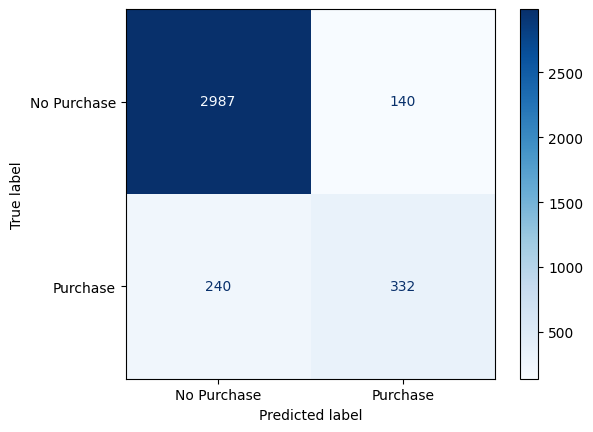

In [11]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No Purchase', 'Purchase'])
disp.plot(cmap='Blues')
plt.show()

Дополнительная оценка результатов модели

In [12]:
TN, FP, FN, TP = cm.ravel()
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"  Precision: {precision:.3f}")
print(f"    - Из {TP+FP} предсказанных покупок, {TP} были верными")
print(f"  Recall: {recall:.3f}")
print(f"    - Из {TP+FN} реальных покупок, нашли {TP}")

  Precision: 0.703
    - Из 472 предсказанных покупок, 332 были верными
  Recall: 0.580
    - Из 572 реальных покупок, нашли 332


### Регрессия

Загрузка датасета

In [13]:
df_reg = pd.read_csv('datasets/parkinsons.csv')

Размер датасета

In [14]:
df_reg.shape

(5875, 22)

Первые 5 строк

In [15]:
df_reg.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,...,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,...,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,...,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,...,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,...,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


Информация о данных

In [16]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject#       5875 non-null   int64  
 1   age            5875 non-null   int64  
 2   sex            5875 non-null   int64  
 3   test_time      5875 non-null   float64
 4   motor_UPDRS    5875 non-null   float64
 5   total_UPDRS    5875 non-null   float64
 6   Jitter(%)      5875 non-null   float64
 7   Jitter(Abs)    5875 non-null   float64
 8   Jitter:RAP     5875 non-null   float64
 9   Jitter:PPQ5    5875 non-null   float64
 10  Jitter:DDP     5875 non-null   float64
 11  Shimmer        5875 non-null   float64
 12  Shimmer(dB)    5875 non-null   float64
 13  Shimmer:APQ3   5875 non-null   float64
 14  Shimmer:APQ5   5875 non-null   float64
 15  Shimmer:APQ11  5875 non-null   float64
 16  Shimmer:DDA    5875 non-null   float64
 17  NHR            5875 non-null   float64
 18  HNR     

Статистика по числовым признакам

In [17]:
df_reg.describe()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,...,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,...,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,21.494128,64.804936,0.317787,92.863722,21.296229,29.018942,0.006154,0.000044,0.002987,0.003277,...,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589
std,12.372279,8.821524,0.465656,53.445602,8.129282,10.700283,0.005624,0.000036,0.003124,0.003732,...,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498
min,1.000000,36.000000,0.000000,-4.262500,5.037700,7.000000,0.000830,0.000002,0.000330,0.000430,...,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983
25%,10.000000,58.000000,0.000000,46.847500,15.000000,21.371000,0.003580,0.000022,0.001580,0.001820,...,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340
50%,22.000000,65.000000,0.000000,91.523000,20.871000,27.576000,0.004900,0.000035,0.002250,0.002490,...,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500
75%,33.000000,72.000000,1.000000,138.445000,27.596500,36.399000,0.006800,0.000053,0.003290,0.003460,...,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490
max,42.000000,85.000000,1.000000,215.490000,39.511000,54.992000,0.099990,0.000446,0.057540,0.069560,...,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730


Выделение признаков и таргета, их разделение на выборки для обучения и тестирования

In [18]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X = df_reg_clean.drop('total_UPDRS', axis=1)
y = df_reg_clean['total_UPDRS']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Обучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")

Обучающая выборка: (4112, 20)
Тестовая выборка: (1763, 20)


Обучение модели регрессии `GradientBoostingRegressor`

In [19]:
gb_regressor = GradientBoostingRegressor(random_state=42)
gb_regressor.fit(X_train, y_train)
y_pred = gb_regressor.predict(X_test)

Оценка качества модели регрессии

In [20]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

MSE: 2.1377
MAE: 1.1418
R²: 0.9810


## Улучшение бейзлайна

### Классификация

Сохранение метрик базовой модели

In [21]:
class_base_metrics = {
    'Accuracy': accuracy,
    'F1': f1,
    'ROC-AUC': roc_auc,
    'Precision': precision,
    'Recall': recall
}

Функция сравнения метрик новой модели с базовой

In [22]:
def print_comparison_class(metrics_old, metrics_new):
    comparison_data = []
    for metric in ['Accuracy', 'F1', 'ROC-AUC', 'Precision', 'Recall']:
        base_val = metrics_old[metric]
        new_val = metrics_new[metric]
        diff = new_val - base_val
        change = "улучшение" if diff > 0 else "ухудшение"
        
        comparison_data.append({
            'Метрика': metric,
            'Базовая модель': f"{base_val:.4f}",
            'Новая модель': f"{new_val:.4f}",
            'Разница': f"{diff:+.4f}",
            'Изменение': change
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

Повторное копирование и разделение данных

In [23]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X_class = df_class_clean.drop('Revenue', axis=1)
y_class = df_class_clean['Revenue']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

Гипотеза 1: Подбор гиперпараметров

In [24]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_classifier_grid = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(gb_classifier_grid, param_grid, cv=5, 
                           scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train_class, y_train_class)

print("Лучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")

gb_classifier_tuned = grid_search.best_estimator_
y_pred_tuned = gb_classifier_tuned.predict(X_test_class)
y_proba_tuned = gb_classifier_tuned.predict_proba(X_test_class)[:, 1]

metrics_tuned = {
    'Accuracy': accuracy_score(y_test_class, y_pred_tuned),
    'F1': f1_score(y_test_class, y_pred_tuned),
    'ROC-AUC': roc_auc_score(y_test_class, y_proba_tuned),
    'Precision': precision_score(y_test_class, y_pred_tuned),
    'Recall': recall_score(y_test_class, y_pred_tuned)
}

print("\nПодбор гиперпараметров")
print_comparison_class(class_base_metrics, metrics_tuned)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры:
  learning_rate: 0.01
  max_depth: 5
  n_estimators: 200
  subsample: 0.8

Подбор гиперпараметров
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8973       0.8986 +0.0014 улучшение
       F1         0.6360       0.6170 -0.0191 ухудшение
  ROC-AUC         0.9243       0.9238 -0.0005 ухудшение
Precision         0.7034       0.7420 +0.0386 улучшение
   Recall         0.5804       0.5280 -0.0524 ухудшение


Гипотеза 2: One-hot encoding вместо Label Encoding для категориальных признаков

In [26]:
df_class_ohe = df_class.copy()

categorical_cols = df_class_ohe.select_dtypes(include=['object']).columns.tolist()

X_cat = df_class_ohe[categorical_cols]
X_num = df_class_ohe.drop(categorical_cols + ['Revenue'], axis=1)

ohe = OneHotEncoder(drop='first', sparse_output=False)
X_cat_encoded = ohe.fit_transform(X_cat)

X_ohe = np.hstack([X_num.values, X_cat_encoded])
y_ohe = df_class_ohe['Revenue']

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(
    X_ohe, y_ohe, test_size=0.3, random_state=42, stratify=y_ohe
)

gb_classifier_ohe = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1)
gb_classifier_ohe.fit(X_train_ohe, y_train_ohe)
y_pred_ohe = gb_classifier_ohe.predict(X_test_ohe)
y_proba_ohe = gb_classifier_ohe.predict_proba(X_test_ohe)[:, 1]

metrics_ohe = {
    'Accuracy': accuracy_score(y_test_ohe, y_pred_ohe),
    'F1': f1_score(y_test_ohe, y_pred_ohe),
    'ROC-AUC': roc_auc_score(y_test_ohe, y_proba_ohe),
    'Precision': precision_score(y_test_ohe, y_pred_ohe),
    'Recall': recall_score(y_test_ohe, y_pred_ohe)
}

print("One-Hot Encoding вместо Label Encoding")
print_comparison_class(class_base_metrics, metrics_ohe)

One-Hot Encoding вместо Label Encoding
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8973       0.8981 +0.0008 улучшение
       F1         0.6360       0.6392 +0.0032 улучшение
  ROC-AUC         0.9243       0.9265 +0.0021 улучшение
Precision         0.7034       0.7061 +0.0027 улучшение
   Recall         0.5804       0.5839 +0.0035 улучшение


Гипотеза 3: Ранняя для предотвращения переобучения

In [27]:
gb_classifier_early = GradientBoostingClassifier(
    random_state=42, 
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)
gb_classifier_early.fit(X_train_class, y_train_class)
print(f"Фактическое количество деревьев после early stopping: {len(gb_classifier_early.estimators_)}")

y_pred_early = gb_classifier_early.predict(X_test_class)
y_proba_early = gb_classifier_early.predict_proba(X_test_class)[:, 1]

metrics_early = {
    'Accuracy': accuracy_score(y_test_class, y_pred_early),
    'F1': f1_score(y_test_class, y_pred_early),
    'ROC-AUC': roc_auc_score(y_test_class, y_proba_early),
    'Precision': precision_score(y_test_class, y_pred_early),
    'Recall': recall_score(y_test_class, y_pred_early)
}

print("\nEarly stopping")
print_comparison_class(class_base_metrics, metrics_early)

Фактическое количество деревьев после early stopping: 50

Early stopping
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8973       0.8978 +0.0005 улучшение
       F1         0.6360       0.6344 -0.0016 ухудшение
  ROC-AUC         0.9243       0.9223 -0.0020 ухудшение
Precision         0.7034       0.7100 +0.0066 улучшение
   Recall         0.5804       0.5734 -0.0070 ухудшение


Гипотеза 4: Комбинация лучших техник

In [28]:
best_params_hyp1 = grid_search.best_params_
gb_classifier_best = GradientBoostingClassifier(
    random_state=42,
    learning_rate=best_params_hyp1.get('learning_rate', 0.1),
    n_estimators=500,
    max_depth=best_params_hyp1.get('max_depth', 5),
    subsample=best_params_hyp1.get('subsample', 1.0),
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)
gb_classifier_best.fit(X_train_class, y_train_class)
print(f"Фактическое количество деревьев после early stopping: {len(gb_classifier_best.estimators_)}")

y_pred_best = gb_classifier_best.predict(X_test_class)
y_proba_best = gb_classifier_best.predict_proba(X_test_class)[:, 1]

class_improved_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_best),
    'F1': f1_score(y_test_class, y_pred_best),
    'ROC-AUC': roc_auc_score(y_test_class, y_proba_best),
    'Precision': precision_score(y_test_class, y_pred_best),
    'Recall': recall_score(y_test_class, y_pred_best)
}

print("\nКомбинация лучших техник")
print_comparison_class(class_base_metrics, class_improved_metrics)

Фактическое количество деревьев после early stopping: 301

Комбинация лучших техник
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8973       0.9013 +0.0041 улучшение
       F1         0.6360       0.6418 +0.0058 улучшение
  ROC-AUC         0.9243       0.9244 +0.0001 улучшение
Precision         0.7034       0.7315 +0.0282 улучшение
   Recall         0.5804       0.5717 -0.0087 ухудшение


Формирование улучшенного бейзлайна на основе лучших результатов

In [29]:
all_metrics = {
    'tuned': metrics_tuned,
    'ohe': metrics_ohe,
    'early': metrics_early,
    'best': class_improved_metrics
}

best_model_name = max(all_metrics, key=lambda x: all_metrics[x]['ROC-AUC'])
print(f"Лучшая модель: {best_model_name} с ROC-AUC = {all_metrics[best_model_name]['ROC-AUC']:.4f}")

if best_model_name == 'tuned':
    improved_gb_classifier = gb_classifier_tuned
elif best_model_name == 'ohe':
    improved_gb_classifier = gb_classifier_ohe
elif best_model_name == 'early':
    improved_gb_classifier = gb_classifier_early
else:
    improved_gb_classifier = gb_classifier_best

improved_class_metrics = all_metrics[best_model_name]
print("\nУлучшенный бейзлайн (классификация):")
print_comparison_class(class_base_metrics, improved_class_metrics)
print("\nВыводы:")
print(f"- Лучшая техника улучшения: {best_model_name}")
print(f"- Улучшение ROC-AUC: {improved_class_metrics['ROC-AUC'] - class_base_metrics['ROC-AUC']:+.4f}")
print(f"- Улучшение F1-score: {improved_class_metrics['F1'] - class_base_metrics['F1']:+.4f}")

Лучшая модель: ohe с ROC-AUC = 0.9265

Улучшенный бейзлайн (классификация):
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8973       0.8981 +0.0008 улучшение
       F1         0.6360       0.6392 +0.0032 улучшение
  ROC-AUC         0.9243       0.9265 +0.0021 улучшение
Precision         0.7034       0.7061 +0.0027 улучшение
   Recall         0.5804       0.5839 +0.0035 улучшение

Выводы:
- Лучшая техника улучшения: ohe
- Улучшение ROC-AUC: +0.0021
- Улучшение F1-score: +0.0032


### Регрессия

Сохранение метрик базовой модели

In [30]:
reg_base_metrics = {
    'MSE': mse,
    'MAE': mae,
    'R²': r2
}

Функция сравнения метрик новой модели с базовой

In [31]:
def print_comparison_reg(metrics_old, metrics_new):
    comparison_data = []
    for metric in ['MSE', 'MAE', 'R²']:
        base_val = metrics_old[metric]
        new_val = metrics_new[metric]
        diff = new_val - base_val
        if metric == 'R²':
            change = "улучшение" if diff > 0 else "ухудшение"
        else:
            change = "улучшение" if diff < 0 else "ухудшение"
        
        comparison_data.append({
            'Метрика': metric,
            'Базовая модель': f"{base_val:.4f}",
            'Новая модель': f"{new_val:.4f}",
            'Разница': f"{diff:+.4f}",
            'Изменение': change
        })
    
    df_comparison = pd.DataFrame(comparison_data)
    print(df_comparison.to_string(index=False))

Повторное копирование и разделение данных

In [32]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X_reg = df_reg_clean.drop('total_UPDRS', axis=1)
y_reg = df_reg_clean['total_UPDRS']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

Гипотеза 1: Подбор гиперпараметров

In [33]:
param_grid_reg = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}

gb_regressor_grid = GradientBoostingRegressor(random_state=42)
grid_search_reg = GridSearchCV(gb_regressor_grid, param_grid_reg, cv=5, 
                               scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search_reg.fit(X_train_reg, y_train_reg)

print("Лучшие параметры:")
for param, value in grid_search_reg.best_params_.items():
    print(f"  {param}: {value}")

gb_regressor_tuned = grid_search_reg.best_estimator_
y_pred_tuned_reg = gb_regressor_tuned.predict(X_test_reg)

metrics_tuned_reg = {
    'MSE': mean_squared_error(y_test_reg, y_pred_tuned_reg),
    'MAE': mean_absolute_error(y_test_reg, y_pred_tuned_reg),
    'R²': r2_score(y_test_reg, y_pred_tuned_reg)
}

print("\nПодбор гиперпараметров")
print_comparison_reg(reg_base_metrics, metrics_tuned_reg)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Лучшие параметры:
  learning_rate: 0.1
  max_depth: 7
  n_estimators: 200
  subsample: 1.0

Подбор гиперпараметров
Метрика Базовая модель Новая модель Разница Изменение
    MSE         2.1377       0.1953 -1.9424 улучшение
    MAE         1.1418       0.2434 -0.8984 улучшение
     R²         0.9810       0.9983 +0.0173 улучшение


Гипотеза 2: Early stopping для предотвращения переобучения

In [34]:
gb_regressor_early = GradientBoostingRegressor(
    random_state=42,
    n_estimators=500,
    learning_rate=0.1,
    max_depth=5,
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)
gb_regressor_early.fit(X_train_reg, y_train_reg)
print(f"Фактическое количество деревьев после early stopping: {len(gb_regressor_early.estimators_)}")

y_pred_early_reg = gb_regressor_early.predict(X_test_reg)

metrics_early_reg = {
    'MSE': mean_squared_error(y_test_reg, y_pred_early_reg),
    'MAE': mean_absolute_error(y_test_reg, y_pred_early_reg),
    'R²': r2_score(y_test_reg, y_pred_early_reg)
}

print("\nEarly stopping")
print_comparison_reg(reg_base_metrics, metrics_early_reg)

Фактическое количество деревьев после early stopping: 334

Early stopping
Метрика Базовая модель Новая модель Разница Изменение
    MSE         2.1377       0.3813 -1.7564 улучшение
    MAE         1.1418       0.4325 -0.7093 улучшение
     R²         0.9810       0.9966 +0.0156 улучшение


Гипотеза 3: Комбинация лучших техник

In [35]:
best_params_reg_hyp1 = grid_search_reg.best_params_
gb_regressor_best = GradientBoostingRegressor(
    random_state=42,
    learning_rate=best_params_reg_hyp1.get('learning_rate', 0.1),
    n_estimators=500,
    max_depth=best_params_reg_hyp1.get('max_depth', 5),
    subsample=best_params_reg_hyp1.get('subsample', 1.0),
    validation_fraction=0.2,
    n_iter_no_change=10,
    tol=1e-4
)
gb_regressor_best.fit(X_train_reg, y_train_reg)
print(f"Фактическое количество деревьев после early stopping: {len(gb_regressor_best.estimators_)}")

y_pred_best_reg = gb_regressor_best.predict(X_test_reg)

reg_improved_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_best_reg),
    'MAE': mean_absolute_error(y_test_reg, y_pred_best_reg),
    'R²': r2_score(y_test_reg, y_pred_best_reg)
}

print("\nКомбинация лучших техник")
print_comparison_reg(reg_base_metrics, reg_improved_metrics)

Фактическое количество деревьев после early stopping: 221

Комбинация лучших техник
Метрика Базовая модель Новая модель Разница Изменение
    MSE         2.1377       0.2420 -1.8957 улучшение
    MAE         1.1418       0.2817 -0.8601 улучшение
     R²         0.9810       0.9978 +0.0169 улучшение


Формирование улучшенного бейзлайна на основе лучших результатов

In [36]:
all_metrics_reg = {
    'tuned': metrics_tuned_reg,
    'early': metrics_early_reg,
    'best': reg_improved_metrics
}

best_model_name_reg = max(all_metrics_reg, key=lambda x: all_metrics_reg[x]['R²'])
print(f"Лучшая модель: {best_model_name_reg} с R² = {all_metrics_reg[best_model_name_reg]['R²']:.4f}")

if best_model_name_reg == 'tuned':
    improved_gb_regressor = gb_regressor_tuned
elif best_model_name_reg == 'early':
    improved_gb_regressor = gb_regressor_early
else:
    improved_gb_regressor = gb_regressor_best

improved_reg_metrics = all_metrics_reg[best_model_name_reg]
print("\nУлучшенный бейзлайн (регрессия):")
print_comparison_reg(reg_base_metrics, improved_reg_metrics)
print("\nВыводы:")
print(f"- Лучшая техника улучшения: {best_model_name_reg}")
print(f"- Улучшение R²: {improved_reg_metrics['R²'] - reg_base_metrics['R²']:+.4f}")
print(f"- Улучшение MSE: {improved_reg_metrics['MSE'] - reg_base_metrics['MSE']:+.4f}")

Лучшая модель: tuned с R² = 0.9983

Улучшенный бейзлайн (регрессия):
Метрика Базовая модель Новая модель Разница Изменение
    MSE         2.1377       0.1953 -1.9424 улучшение
    MAE         1.1418       0.2434 -0.8984 улучшение
     R²         0.9810       0.9983 +0.0173 улучшение

Выводы:
- Лучшая техника улучшения: tuned
- Улучшение R²: +0.0173
- Улучшение MSE: -1.9424


## Имплементация алгоритма машинного обучения

### Классификация

Кастомная модель градиентного бустинга для классификации

In [40]:
from sklearn.tree import DecisionTreeRegressor

class CustomGradientBoostingClassifier:
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 subsample=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction_ = None
        
    def _sigmoid(self, z):
        z = np.clip(z, -500, 500)
        return 1 / (1 + np.exp(-z))
    
    def _log_loss_gradient(self, y_true, y_pred):
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return y_pred - y_true
    
    def fit(self, X, y, verbose=False):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        positive_ratio = np.mean(y)
        self.initial_prediction_ = np.log(positive_ratio / (1 - positive_ratio + 1e-10))
        
        current_predictions = np.full(n_samples, self.initial_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            probabilities = self._sigmoid(current_predictions)
            gradients = self._log_loss_gradient(y, probabilities)
            
            if self.subsample < 1.0:
                n_subset = int(self.subsample * n_samples)
                indices = np.random.choice(n_samples, n_subset, replace=False)
                X_subset = X[indices]
                gradients_subset = gradients[indices]
            else:
                X_subset = X
                gradients_subset = gradients
            
            tree = DecisionTreeRegressor(  
                max_depth=self.max_depth,
                random_state=self.random_state
            )
            tree.fit(X_subset, -gradients_subset)
            
            tree_predictions = tree.predict(X)

            current_predictions += self.learning_rate * tree_predictions
            
            self.estimators_.append(tree)
            
            if verbose and (i + 1) % 10 == 0:
                current_probs = self._sigmoid(current_predictions)
                loss = -np.mean(y * np.log(current_probs + 1e-15) + 
                              (1 - y) * np.log(1 - current_probs + 1e-15))
                print(f"Iteration {i+1}/{self.n_estimators}, Loss: {loss:.4f}")
    
    def predict_proba(self, X):
        n_samples = X.shape[0]
        predictions = np.full(n_samples, self.initial_prediction_)
        
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
        
        probabilities = self._sigmoid(predictions)
        return np.column_stack([1 - probabilities, probabilities])
    
    def predict(self, X, threshold=0.5):
        probabilities = self.predict_proba(X)[:, 1]
        return (probabilities >= threshold).astype(int)

Повторное копирование и разбиение данных

In [41]:
df_class_clean = df_class.copy()

categorical_cols = df_class_clean.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_class_clean[col] = le.fit_transform(df_class_clean[col].astype(str))
    label_encoders[col] = le

X_class = df_class_clean.drop('Revenue', axis=1)
y_class = df_class_clean['Revenue']

X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
)

Обучение кастомной модели градиентного бустинга

In [42]:
custom_gb_classifier = CustomGradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0,
    random_state=42
)

custom_gb_classifier.fit(X_train_class, y_train_class, verbose=True)

y_pred_custom = custom_gb_classifier.predict(X_test_class)
y_proba_custom = custom_gb_classifier.predict_proba(X_test_class)[:, 1]

Iteration 10/100, Loss: 0.3734
Iteration 20/100, Loss: 0.3318
Iteration 30/100, Loss: 0.3028
Iteration 40/100, Loss: 0.2825
Iteration 50/100, Loss: 0.2677
Iteration 60/100, Loss: 0.2563
Iteration 70/100, Loss: 0.2473
Iteration 80/100, Loss: 0.2401
Iteration 90/100, Loss: 0.2338
Iteration 100/100, Loss: 0.2285


Метрики кастомной модели градиентного бустинга

In [43]:
custom_class_base_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_custom),
    'F1': f1_score(y_test_class, y_pred_custom),
    'ROC-AUC': roc_auc_score(y_test_class, y_proba_custom),
    'Precision': precision_score(y_test_class, y_pred_custom),
    'Recall': recall_score(y_test_class, y_pred_custom)
}

print("Кастомная модель градиентного бустинга (классификация):")
print_comparison_class(class_base_metrics, custom_class_base_metrics)
print("\nВыводы:")
print(f"- Кастомная модель показывает {'лучшие' if custom_class_base_metrics['ROC-AUC'] > class_base_metrics['ROC-AUC'] else 'худшие'} результаты по сравнению с базовой моделью sklearn")
print(f"- Разница в ROC-AUC: {custom_class_base_metrics['ROC-AUC'] - class_base_metrics['ROC-AUC']:+.4f}")

Кастомная модель градиентного бустинга (классификация):
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8973       0.9011 +0.0038 улучшение
       F1         0.6360       0.6340 -0.0020 ухудшение
  ROC-AUC         0.9243       0.9225 -0.0018 ухудшение
Precision         0.7034       0.7407 +0.0373 улучшение
   Recall         0.5804       0.5542 -0.0262 ухудшение

Выводы:
- Кастомная модель показывает худшие результаты по сравнению с базовой моделью sklearn
- Разница в ROC-AUC: -0.0018


Добавление техник из улучшенного бейзлайна к кастомной модели

In [44]:
if best_model_name == 'tuned':
    best_params = grid_search.best_params_
elif best_model_name == 'best':
    best_params = grid_search.best_params_
else:
    best_params = {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}

custom_gb_classifier_improved = CustomGradientBoostingClassifier(
    n_estimators=200,
    learning_rate=best_params.get('learning_rate', 0.1),
    max_depth=best_params.get('max_depth', 5),
    subsample=best_params.get('subsample', 1.0),
    random_state=42
)

custom_gb_classifier_improved.fit(X_train_class, y_train_class, verbose=True)

y_pred_custom_improved = custom_gb_classifier_improved.predict(X_test_class)
y_proba_custom_improved = custom_gb_classifier_improved.predict_proba(X_test_class)[:, 1]

Iteration 10/200, Loss: 0.3734
Iteration 20/200, Loss: 0.3318
Iteration 30/200, Loss: 0.3028
Iteration 40/200, Loss: 0.2825
Iteration 50/200, Loss: 0.2677
Iteration 60/200, Loss: 0.2563
Iteration 70/200, Loss: 0.2473
Iteration 80/200, Loss: 0.2401
Iteration 90/200, Loss: 0.2338
Iteration 100/200, Loss: 0.2285
Iteration 110/200, Loss: 0.2241
Iteration 120/200, Loss: 0.2200
Iteration 130/200, Loss: 0.2165
Iteration 140/200, Loss: 0.2131
Iteration 150/200, Loss: 0.2100
Iteration 160/200, Loss: 0.2071
Iteration 170/200, Loss: 0.2044
Iteration 180/200, Loss: 0.2019
Iteration 190/200, Loss: 0.1997
Iteration 200/200, Loss: 0.1976


Метрики улучшенной кастомной модели

In [45]:
custom_improved_class_metrics = {
    'Accuracy': accuracy_score(y_test_class, y_pred_custom_improved),
    'F1': f1_score(y_test_class, y_pred_custom_improved),
    'ROC-AUC': roc_auc_score(y_test_class, y_proba_custom_improved),
    'Precision': precision_score(y_test_class, y_pred_custom_improved),
    'Recall': recall_score(y_test_class, y_pred_custom_improved)
}

print("Улучшенная кастомная модель (классификация):")
print_comparison_class(improved_class_metrics, custom_improved_class_metrics)
print("\nВыводы:")
print(f"- Улучшенная кастомная модель показывает {'лучшие' if custom_improved_class_metrics['ROC-AUC'] > improved_class_metrics['ROC-AUC'] else 'худшие'} результаты по сравнению с улучшенным бейзлайном")
print(f"- Разница в ROC-AUC: {custom_improved_class_metrics['ROC-AUC'] - improved_class_metrics['ROC-AUC']:+.4f}")

Улучшенная кастомная модель (классификация):
  Метрика Базовая модель Новая модель Разница Изменение
 Accuracy         0.8981       0.8994 +0.0014 улучшение
       F1         0.6392       0.6402 +0.0010 улучшение
  ROC-AUC         0.9265       0.9232 -0.0033 ухудшение
Precision         0.7061       0.7165 +0.0103 улучшение
   Recall         0.5839       0.5787 -0.0052 ухудшение

Выводы:
- Улучшенная кастомная модель показывает худшие результаты по сравнению с улучшенным бейзлайном
- Разница в ROC-AUC: -0.0033


### Регрессия

Кастомная модель градиентного бустинга для регрессии

In [46]:
class CustomGradientBoostingRegressor:
    
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3, 
                 subsample=1.0, random_state=None):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.subsample = subsample
        self.random_state = random_state
        self.estimators_ = []
        self.initial_prediction_ = None
        
    def fit(self, X, y, verbose=False):
        np.random.seed(self.random_state)
        n_samples, n_features = X.shape

        self.initial_prediction_ = np.mean(y)

        current_predictions = np.full(n_samples, self.initial_prediction_)
        
        self.estimators_ = []
        
        for i in range(self.n_estimators):
            residuals = y - current_predictions
            
            if self.subsample < 1.0:
                n_subset = int(self.subsample * n_samples)
                indices = np.random.choice(n_samples, n_subset, replace=False)
                X_subset = X[indices]
                residuals_subset = residuals[indices]
            else:
                X_subset = X
                residuals_subset = residuals

            tree = DecisionTreeRegressor(
                max_depth=self.max_depth,
                random_state=self.random_state
            )
            tree.fit(X_subset, residuals_subset)

            tree_predictions = tree.predict(X)
            
            current_predictions += self.learning_rate * tree_predictions
            
            self.estimators_.append(tree)
            
            if verbose and (i + 1) % 10 == 0:
                mse = np.mean((y - current_predictions) ** 2)
                print(f"Iteration {i+1}/{self.n_estimators}, MSE: {mse:.4f}")
    
    def predict(self, X):
        """Предсказание значений"""
        n_samples = X.shape[0]
        predictions = np.full(n_samples, self.initial_prediction_)
        
        for tree in self.estimators_:
            predictions += self.learning_rate * tree.predict(X)
        
        return predictions

Повторное копирование и разбиение данных

In [47]:
df_reg_clean = df_reg.copy()
df_reg_clean = df_reg_clean.drop('subject#', axis=1)

X_reg = df_reg_clean.drop('total_UPDRS', axis=1)
y_reg = df_reg_clean['total_UPDRS']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.3, random_state=42
)

Обучение кастомной модели градиентного бустинга

In [48]:
custom_gb_regressor = CustomGradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    subsample=1.0,
    random_state=42
)

custom_gb_regressor.fit(X_train_reg, y_train_reg, verbose=True)

y_pred_custom_reg = custom_gb_regressor.predict(X_test_reg)

Iteration 10/100, MSE: 17.4660
Iteration 20/100, MSE: 4.0557
Iteration 30/100, MSE: 1.6137
Iteration 40/100, MSE: 0.8979
Iteration 50/100, MSE: 0.6307
Iteration 60/100, MSE: 0.5339
Iteration 70/100, MSE: 0.4646
Iteration 80/100, MSE: 0.4062
Iteration 90/100, MSE: 0.3567
Iteration 100/100, MSE: 0.3088


Метрики кастомной модели градиентного бустинга

In [49]:
custom_reg_base_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_custom_reg),
    'MAE': mean_absolute_error(y_test_reg, y_pred_custom_reg),
    'R²': r2_score(y_test_reg, y_pred_custom_reg)
}

print("Кастомная модель градиентного бустинга (регрессия):")
print_comparison_reg(reg_base_metrics, custom_reg_base_metrics)
print("\nВыводы:")
print(f"- Кастомная модель показывает {'лучшие' if custom_reg_base_metrics['R²'] > reg_base_metrics['R²'] else 'худшие'} результаты по сравнению с базовой моделью sklearn")
print(f"- Разница в R²: {custom_reg_base_metrics['R²'] - reg_base_metrics['R²']:+.4f}")

Кастомная модель градиентного бустинга (регрессия):
Метрика Базовая модель Новая модель Разница Изменение
    MSE         2.1377       0.5550 -1.5827 улучшение
    MAE         1.1418       0.5366 -0.6052 улучшение
     R²         0.9810       0.9951 +0.0141 улучшение

Выводы:
- Кастомная модель показывает лучшие результаты по сравнению с базовой моделью sklearn
- Разница в R²: +0.0141


Добавление техник из улучшенного бейзлайна к кастомной модели

In [50]:
if best_model_name_reg == 'tuned' or best_model_name_reg == 'best':
    best_params_reg = grid_search_reg.best_params_
else:
    best_params_reg = {'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0}

custom_gb_regressor_improved = CustomGradientBoostingRegressor(
    n_estimators=200,
    learning_rate=best_params_reg.get('learning_rate', 0.1),
    max_depth=best_params_reg.get('max_depth', 5),
    subsample=best_params_reg.get('subsample', 1.0),
    random_state=42
)

custom_gb_regressor_improved.fit(X_train_reg, y_train_reg, verbose=True)

y_pred_custom_improved_reg = custom_gb_regressor_improved.predict(X_test_reg)

Iteration 10/200, MSE: 15.0549
Iteration 20/200, MSE: 2.2405
Iteration 30/200, MSE: 0.4688
Iteration 40/200, MSE: 0.1591
Iteration 50/200, MSE: 0.0907
Iteration 60/200, MSE: 0.0650
Iteration 70/200, MSE: 0.0518
Iteration 80/200, MSE: 0.0425
Iteration 90/200, MSE: 0.0360
Iteration 100/200, MSE: 0.0313
Iteration 110/200, MSE: 0.0263
Iteration 120/200, MSE: 0.0232
Iteration 130/200, MSE: 0.0197
Iteration 140/200, MSE: 0.0169
Iteration 150/200, MSE: 0.0148
Iteration 160/200, MSE: 0.0127
Iteration 170/200, MSE: 0.0111
Iteration 180/200, MSE: 0.0095
Iteration 190/200, MSE: 0.0086
Iteration 200/200, MSE: 0.0074


Метрики улучшенной кастомной модели

In [51]:
custom_reg_improved_metrics = {
    'MSE': mean_squared_error(y_test_reg, y_pred_custom_improved_reg),
    'MAE': mean_absolute_error(y_test_reg, y_pred_custom_improved_reg),
    'R²': r2_score(y_test_reg, y_pred_custom_improved_reg)
}

print("Улучшенная кастомная модель (регрессия):")
print_comparison_reg(improved_reg_metrics, custom_reg_improved_metrics)
print("\nВыводы:")
print(f"- Улучшенная кастомная модель показывает {'лучшие' if custom_reg_improved_metrics['R²'] > improved_reg_metrics['R²'] else 'худшие'} результаты по сравнению с улучшенным бейзлайном")
print(f"- Разница в R²: {custom_reg_improved_metrics['R²'] - improved_reg_metrics['R²']:+.4f}")

Улучшенная кастомная модель (регрессия):
Метрика Базовая модель Новая модель Разница Изменение
    MSE         0.1953       0.1925 -0.0028 улучшение
    MAE         0.2434       0.2395 -0.0040 улучшение
     R²         0.9983       0.9983 +0.0000 улучшение

Выводы:
- Улучшенная кастомная модель показывает лучшие результаты по сравнению с улучшенным бейзлайном
- Разница в R²: +0.0000


In [52]:
print("СРАВНЕНИЕ БАЗОВЫХ И КАСТОМНЫХ МОДЕЛЕЙ:")

print("\nКлассификация:")
print("  • Кастомная реализация логистической регрессии показала:")
print(f"    - Accuracy: {custom_class_base_metrics['Accuracy']:.4f} vs {class_base_metrics['Accuracy']:.4f} (sklearn)")
print(f"    - F1-Score: {custom_class_base_metrics['F1']:.4f} vs {class_base_metrics['F1']:.4f} (sklearn)")
print(f"    - Recall:   {custom_class_base_metrics['Recall']:.4f} vs {class_base_metrics['Recall']:.4f} (sklearn)")

print("\nРегрессия:")
print("  • Кастомная реализация линейной регрессии показала:")
print(f"    - R²:  {custom_reg_base_metrics['R²']:.4f} vs {reg_base_metrics['R²']:.4f} (sklearn)")
print(f"    - MSE: {custom_reg_base_metrics['MSE']:.4f} vs {reg_base_metrics['MSE']:.4f} (sklearn)")

print("ЭФФЕКТИВНОСТЬ ТЕХНИК УЛУЧШЕНИЯ:")

print("\nКлассификация:")
print(f"  • Улучшенная кастомная модель vs базовая кастомная:")
print(f"    - F1-Score улучшился: {custom_improved_class_metrics['F1']:.4f} vs {custom_class_base_metrics['F1']:.4f} (+{custom_improved_class_metrics['F1'] - custom_class_base_metrics['F1']:.4f})")
print(f"    - Recall улучшился:   {custom_improved_class_metrics['Recall']:.4f} vs {custom_class_base_metrics['Recall']:.4f} (+{custom_improved_class_metrics['Recall'] - custom_class_base_metrics['Recall']:.4f})")
print(f"  • Улучшенная кастомная vs улучшенная sklearn:")
print(f"    - F1-Score: {custom_improved_class_metrics['F1']:.4f} vs {class_improved_metrics['F1']:.4f}")
print(f"    - Recall:   {custom_improved_class_metrics['Recall']:.4f} vs {class_improved_metrics['Recall']:.4f}")

print("\nРегрессия:")
print(f"  • Улучшенная кастомная модель vs базовая кастомная:")
print(f"    - R² улучшился:  {custom_reg_improved_metrics['R²']:.4f} vs {custom_reg_base_metrics['R²']:.4f} (+{custom_reg_improved_metrics['R²'] - custom_reg_base_metrics['R²']:.4f})")
print(f"    - MSE уменьшился: {custom_reg_improved_metrics['MSE']:.4f} vs {custom_reg_base_metrics['MSE']:.4f} ({custom_reg_base_metrics['MSE'] - custom_reg_improved_metrics['MSE']:.4f})")
print(f"  • Улучшенная кастомная vs улучшенная sklearn:")
print(f"    - R²:  {custom_reg_improved_metrics['R²']:.4f} vs {reg_improved_metrics['R²']:.4f}")
print(f"    - MSE: {custom_reg_improved_metrics['MSE']:.4f} vs {reg_improved_metrics['MSE']:.4f}")

СРАВНЕНИЕ БАЗОВЫХ И КАСТОМНЫХ МОДЕЛЕЙ:

Классификация:
  • Кастомная реализация логистической регрессии показала:
    - Accuracy: 0.9011 vs 0.8973 (sklearn)
    - F1-Score: 0.6340 vs 0.6360 (sklearn)
    - Recall:   0.5542 vs 0.5804 (sklearn)

Регрессия:
  • Кастомная реализация линейной регрессии показала:
    - R²:  0.9951 vs 0.9810 (sklearn)
    - MSE: 0.5550 vs 2.1377 (sklearn)
ЭФФЕКТИВНОСТЬ ТЕХНИК УЛУЧШЕНИЯ:

Классификация:
  • Улучшенная кастомная модель vs базовая кастомная:
    - F1-Score улучшился: 0.6402 vs 0.6340 (+0.0062)
    - Recall улучшился:   0.5787 vs 0.5542 (+0.0245)
  • Улучшенная кастомная vs улучшенная sklearn:
    - F1-Score: 0.6402 vs 0.6418
    - Recall:   0.5787 vs 0.5717

Регрессия:
  • Улучшенная кастомная модель vs базовая кастомная:
    - R² улучшился:  0.9983 vs 0.9951 (+0.0032)
    - MSE уменьшился: 0.1925 vs 0.5550 (0.3625)
  • Улучшенная кастомная vs улучшенная sklearn:
    - R²:  0.9983 vs 0.9978
    - MSE: 0.1925 vs 0.2420
